In [1]:
import os
import gc
import zipfile
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, precision_recall_curve
)

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
path = kagglehub.dataset_download("ethon0426/lending-club-20072020q1")
print(path)

file_path = path + "/Loan_status_2007-2020Q3.gzip"

# df = pd.read_csv(file_path, low_memory=False)
# print(df.shape)
# print(df.head())

/Users/abao/.cache/kagglehub/datasets/ethon0426/lending-club-20072020q1/versions/3


In [3]:
ROW_LIMIT = 10000   # Change this parameter to control the input number of rows

read_kwargs = dict(low_memory=False, compression="infer")
if ROW_LIMIT is not None:
    read_kwargs["nrows"] = ROW_LIMIT

df = pd.read_csv(file_path, **read_kwargs)
print(df.shape)
print(df.head())

(10000, 142)
   Unnamed: 0       id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0           0  1077501       5000         5000           4975.0   36 months   
1           1  1077430       2500         2500           2500.0   60 months   
2           2  1077175       2400         2400           2400.0   36 months   
3           3  1076863      10000        10000          10000.0   36 months   
4           4  1075358       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... hardship_start_date  \
0   10.65%       162.87     B        B2  ...                 NaN   
1   15.27%        59.83     C        C4  ...                 NaN   
2   15.96%        84.33     C        C5  ...                 NaN   
3   13.49%       339.31     C        C1  ...                 NaN   
4   12.69%        67.79     B        B5  ...                 NaN   

  hardship_end_date payment_plan_start_date  hardship_length hardship_dpd  \
0               NaN       

In [4]:
TARGET_COL = "loan_status"
if TARGET_COL not in df.columns:
    raise KeyError(f"`{TARGET_COL}` not found")

keep_status = ["Fully Paid", "Charged Off"]
df = df[df[TARGET_COL].isin(keep_status)].copy()
df["target"] = (df[TARGET_COL] == "Charged Off").astype(int)
df.drop(columns=[TARGET_COL], inplace=True)

numeric_features = [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti",
    "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util",
    "total_acc"
]
categorical_features = [
    "term", "grade", "sub_grade", "emp_length", "home_ownership",
    "verification_status", "purpose", "application_type"
]

numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]

for col in ["int_rate", "revol_util"]:
    if col in df.columns and df[col].dtype == object:
        df[col] = pd.to_numeric(df[col].astype(str).str.rstrip("%"), errors="coerce")

for col in numeric_features:
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [5]:
X = df[numeric_features + categorical_features].copy()
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Training datasets with pos and neg samples
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = (neg / max(1, pos)) if pos > 0 else 1.0



numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

preprocess.fit(X_train)
X_train_tr = preprocess.transform(X_train)
X_test_tr  = preprocess.transform(X_test)

In [6]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    n_jobs=os.cpu_count(),
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc"
)

xgb_model.fit(
    X_train_tr, y_train,
    eval_set=[(X_train_tr, y_train), (X_test_tr, y_test)],
    verbose=50
)

[0]	validation_0-auc:0.73115	validation_1-auc:0.65935
[50]	validation_0-auc:0.85947	validation_1-auc:0.70018
[100]	validation_0-auc:0.91663	validation_1-auc:0.69746
[150]	validation_0-auc:0.95188	validation_1-auc:0.69798
[200]	validation_0-auc:0.97219	validation_1-auc:0.69071
[250]	validation_0-auc:0.98510	validation_1-auc:0.68897
[300]	validation_0-auc:0.99202	validation_1-auc:0.68333
[350]	validation_0-auc:0.99557	validation_1-auc:0.67862
[400]	validation_0-auc:0.99782	validation_1-auc:0.67664
[450]	validation_0-auc:0.99891	validation_1-auc:0.67617
[499]	validation_0-auc:0.99945	validation_1-auc:0.67646


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [7]:
proba = xgb_model.predict_proba(X_test_tr)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC: ", roc_auc_score(y_test, proba))
print("PR-AUC:  ", average_precision_score(y_test, proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred, digits=4))


# Model Saving
# os.makedirs("artifacts", exist_ok=True)
# joblib.dump({"preprocess": preprocess, "xgb": xgb}, "artifacts/xgb_lc_2007_2020Q3.joblib")
# print("artifacts/xgb_lc_2007_2020Q3.joblib")

ROC-AUC:  0.676462588117959
PR-AUC:   0.2586972486693209
Confusion Matrix:
 [[1453  233]
 [ 216   98]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8706    0.8618    0.8662      1686
           1     0.2961    0.3121    0.3039       314

    accuracy                         0.7755      2000
   macro avg     0.5833    0.5870    0.5850      2000
weighted avg     0.7804    0.7755    0.7779      2000



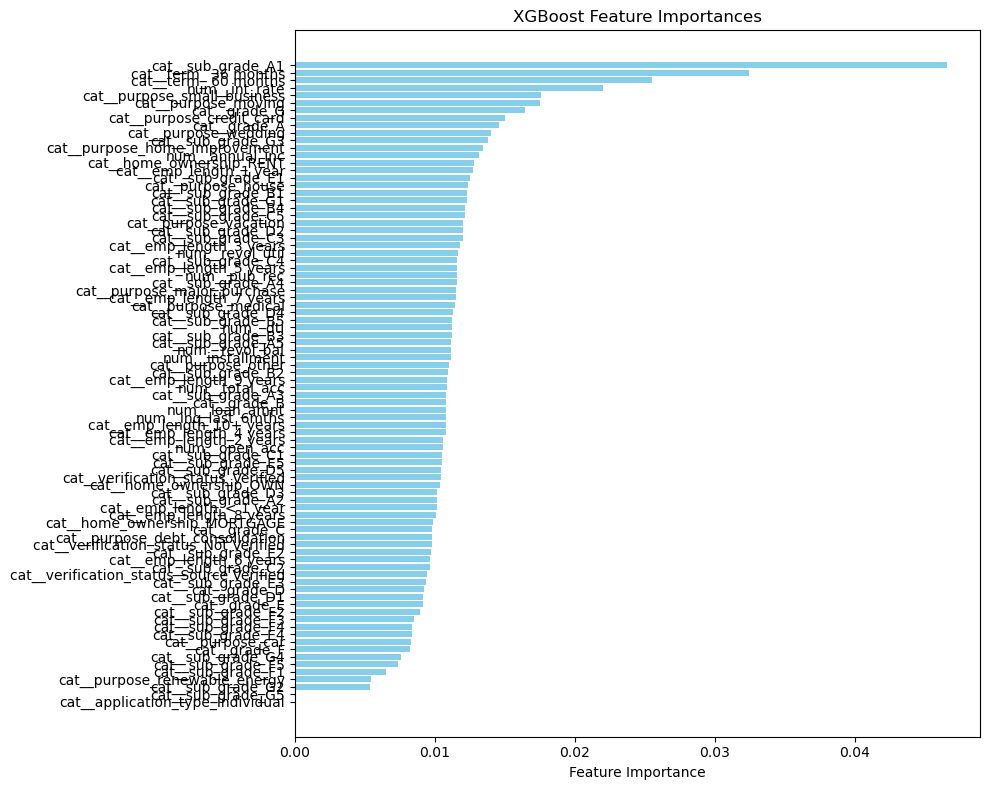

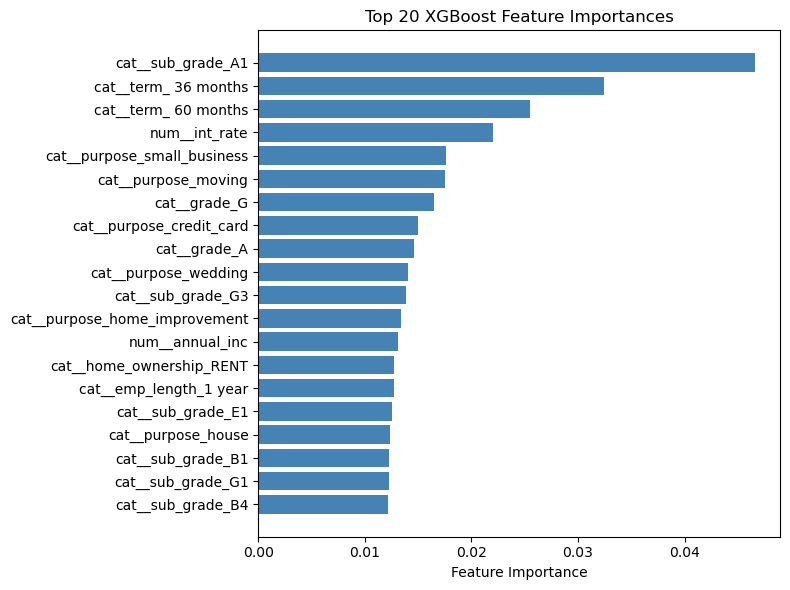

In [8]:

# Get feature names from your ColumnTransformer
feature_names = preprocess.get_feature_names_out()

# Get feature importances from the trained XGBClassifier
importances = xgb_model.feature_importances_

# Put into DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=True)

# Plot all features
plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# (Optional) Plot only the Top N features
topn = 20
plt.figure(figsize=(8, 6))
top_df = importance_df.tail(topn)
plt.barh(top_df["Feature"], top_df["Importance"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title(f"Top {topn} XGBoost Feature Importances")
plt.tight_layout()
plt.show()


Numeric columns going into model: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recen

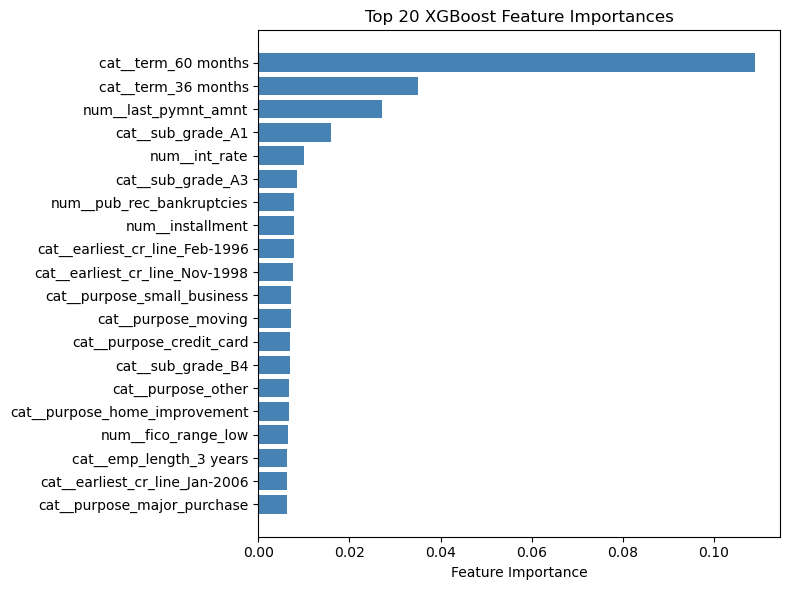

In [9]:


# -------------------
# 1. Target setup
# -------------------

# -------------------
# 2. Drop leakage / ID / text columns
# -------------------
drop_cols = [
    "Unnamed: 0","id","emp_title","url","title","zip_code","addr_state",
    "issue_d","last_pymnt_d","next_pymnt_d","last_credit_pull_d",
    "out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
    "total_rec_prncp","total_rec_int","total_rec_late_fee",
    "recoveries","collection_recovery_fee",
    "last_fico_range_high","last_fico_range_low",
    "hardship_flag","hardship_type","hardship_reason","hardship_status",
    "deferral_term","hardship_amount","hardship_start_date","hardship_end_date",
    "payment_plan_start_date","hardship_length","hardship_dpd",
    "hardship_loan_status","orig_projected_additional_accrued_interest",
    "hardship_payoff_balance_amount","hardship_last_payment_amount",
    "debt_settlement_flag"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# -------------------
# 3. Clean percentage strings
# -------------------
percent_cols = ["int_rate", "revol_util", "sec_app_revol_util"]
for col in percent_cols:
    if col in df.columns and df[col].dtype == object:
        df[col] = pd.to_numeric(
            df[col].astype(str).str.strip().str.rstrip("%"),
            errors="coerce"
        )

# -------------------
# 4. Strip whitespace in categorical variables
# -------------------
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()

# -------------------
# 5. Save a copy of cleaned dataframe (to see included cols)
# -------------------
df_cleaned = df.copy()
print("Numeric columns going into model:", df_cleaned.select_dtypes(include=[np.number]).drop(columns=["target"]).columns.tolist())
print("Categorical columns going into model:", df_cleaned.select_dtypes(include=["object"]).columns.tolist())

# -------------------
# 6. Split features into numeric vs categorical
# -------------------
numeric_features = df_cleaned.select_dtypes(include=[np.number]).drop(columns=["target"]).columns.tolist()
categorical_features = df_cleaned.select_dtypes(include=["object"]).columns.tolist()

# -------------------
# 7. Preprocessors
# -------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# -------------------
# 8. Full pipeline with XGBClassifier
# -------------------
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

# -------------------
# 9. Train/test split + train
# -------------------
X = df_cleaned.drop(columns=["target"])
y = df_cleaned["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

xgb_model.fit(X_train, y_train)

# -------------------
# 10. Evaluation
# -------------------
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# -------------------
# 11. Feature importances
# -------------------
# Recover feature names after preprocessing
feature_names = xgb_model.named_steps["preprocess"].get_feature_names_out()
importances = xgb_model.named_steps["classifier"].feature_importances_

# Build dataframe
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=True)

# Plot top 20
plt.figure(figsize=(8, 6))
top_df = importance_df.tail(20)
plt.barh(top_df["Feature"], top_df["Importance"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()


Numeric: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'policy_code', 'delinq_2yrs', 'mths_since_last_delinq', 'num_accts_ever_120_pd', 'fico_range_low', 'inq_last_6mths', 'mths_since_recent_inq', 'open_acc', 'total_acc', 'mort_acc', 'revol_bal', 'revol_util', 'total_rev_hi_lim', 'total_bal_il', 'il_util', 'all_util', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_actv_rev_tl', 'num_il_tl', 'num_bc_tl', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'annual_inc_joint', 'dti_joint']
Categorical: []
ROC-AUC: 0.6593754486176909
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1686
           1       0.25      0.04      0.08       314

    accuracy                           0.83      2000
   macro avg       0.55      0.51      0.49      2000
weighted avg       0.75      0.83      0.78      2000

[[1645   41]
 [ 300   14]]


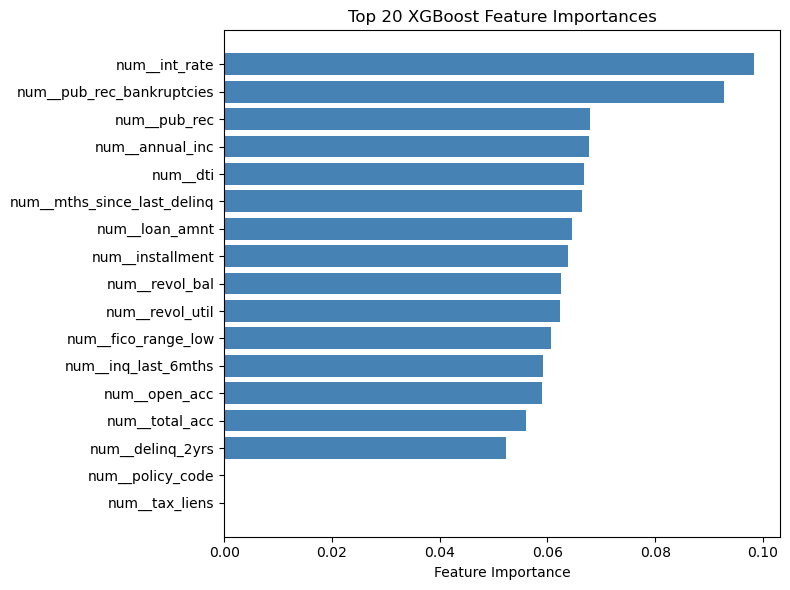

In [10]:

#2 REDUCED FEATURE SPACE


selected_features = [
    # Loan info
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti", "policy_code",

    # Credit history (delinquencies)
    "delinq_2yrs", "mths_since_last_delinq", "num_accts_ever_120_pd",

    # FICO (average instead of both low/high)
    "fico_range_low",  # (could collapse to avg later)

    # Inquiries
    "inq_last_6mths", "mths_since_recent_inq",

    # Accounts
    "open_acc", "total_acc", "mort_acc",

    # Revolving credit
    "revol_bal", "revol_util", "total_rev_hi_lim",

    # Installment balances/utilization
    "total_bal_il", "il_util", "all_util",

    # Aging metrics
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op",

    # Counts of tradelines
    "num_rev_accts", "num_rev_tl_bal_gt_0", "num_actv_rev_tl",
    "num_il_tl", "num_bc_tl",

    # Ratios
    "pct_tl_nvr_dlq", "percent_bc_gt_75",

    # Derogs/bankruptcy
    "pub_rec", "pub_rec_bankruptcies", "tax_liens",

    # Joint features (optional — drop if mostly NaN)
    "annual_inc_joint", "dti_joint"
]
ARGET_COL = "loan_status"
keep_status = ["Fully Paid", "Charged Off"]

df_model = df.copy()

# -------------------
# 2. Subset to selected features
# -------------------
X = df_model[selected_features].copy()
y = df_model["target"]

# -------------------
# 3. Clean percentages
# -------------------
for col in ["int_rate", "revol_util"]:
    if col in X.columns and X[col].dtype == object:
        X[col] = pd.to_numeric(X[col].astype(str).str.strip().str.rstrip("%"), errors="coerce")

# -------------------
# 4. Split numeric vs categorical
# -------------------
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

# -------------------
# 5. Preprocessors
# -------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# -------------------
# 6. Full pipeline
# -------------------
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

# -------------------
# 7. Train/test split
# -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------
# 8. Train model
# -------------------
xgb_model.fit(X_train, y_train)

# -------------------
# 9. Evaluation
# -------------------
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# -------------------
# 10. Feature Importances
# -------------------
feature_names = xgb_model.named_steps["preprocess"].get_feature_names_out()
importances = xgb_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(8, 6))
top_df = importance_df.tail(20)
plt.barh(top_df["Feature"], top_df["Importance"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()


ROC-AUC: 0.8494816812868812
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1686
           1       0.60      0.29      0.39       314

    accuracy                           0.86      2000
   macro avg       0.74      0.63      0.65      2000
weighted avg       0.84      0.86      0.84      2000

[[1627   59]
 [ 224   90]]
           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
8462 -2.331256  2.574783 -0.481804  1.386681 -1.019230  0.877263  1.564835   
8224 -1.660931 -0.099557 -0.716093 -0.171166 -0.768920 -1.098185 -0.370613   
4021  0.172834  3.327126 -0.080641  0.924734 -1.598332  0.736103 -0.581917   
5228 -1.797239 -0.875861  0.344453 -1.297971  2.594508 -0.062220  0.053288   
4269 -2.792626  1.200390  0.771827 -1.356216  0.109926 -0.124111  0.245654   

           PC8       PC9      PC10  ...      PC42      PC43      PC44  \
8462  0.492186 -2.126272  0.024483  ... -0.167952 -0.057071 -0.408701   
822

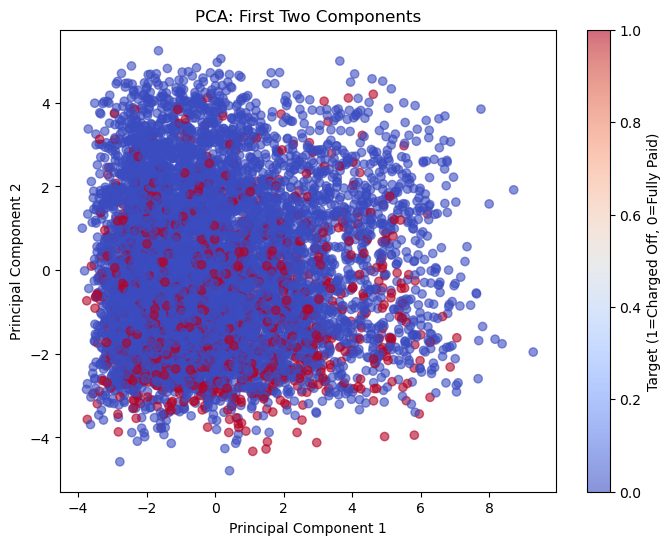

Top contributing features to PC1:
num__funded_amnt        0.427997
num__funded_amnt_inv    0.427606
num__loan_amnt          0.426480
num__installment        0.409553
num__last_pymnt_amnt    0.235481
num__annual_inc         0.213472
num__revol_bal          0.206925
num__total_acc          0.183271
num__int_rate           0.157289
num__open_acc           0.133788
Name: PC1, dtype: float64
Top contributing features to PC2:
num__fico_range_high         0.514067
num__fico_range_low          0.514067
num__int_rate               -0.444620
num__revol_util             -0.369514
cat__grade_A                 0.166188
num__pub_rec                -0.135649
num__dti                    -0.131314
num__pub_rec_bankruptcies   -0.126828
num__delinq_2yrs            -0.122668
num__total_acc               0.064503
Name: PC2, dtype: float64


In [11]:

#PCA Analysis


# -------------------
# 2. Drop leakage / ID / text columns
# -------------------
drop_cols = [
    "Unnamed: 0","id","emp_title","url","title","zip_code","addr_state",
    "issue_d","last_pymnt_d","next_pymnt_d","last_credit_pull_d",
    "out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
    "total_rec_prncp","total_rec_int","total_rec_late_fee",
    "recoveries","collection_recovery_fee",
    "last_fico_range_high","last_fico_range_low",
    "hardship_flag","hardship_type","hardship_reason","hardship_status",
    "deferral_term","hardship_amount","hardship_start_date","hardship_end_date",
    "payment_plan_start_date","hardship_length","hardship_dpd",
    "hardship_loan_status","orig_projected_additional_accrued_interest",
    "hardship_payoff_balance_amount","hardship_last_payment_amount",
    "debt_settlement_flag"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# -------------------
# 3. Clean percentage strings
# -------------------
percent_cols = ["int_rate", "revol_util", "sec_app_revol_util"]
for col in percent_cols:
    if col in df.columns and df[col].dtype == object:
        df[col] = pd.to_numeric(
            df[col].astype(str).str.strip().str.rstrip("%"),
            errors="coerce"
        )

# -------------------
# 4. Strip whitespace in categorical variables
# -------------------
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()

# -------------------
# 5. Save a copy of cleaned dataframe
# -------------------
df_cleaned = df.copy()

# -------------------
# 6. Split features into numeric vs categorical
# -------------------
numeric_features = df_cleaned.select_dtypes(include=[np.number]).drop(columns=["target"]).columns.tolist()
categorical_features = df_cleaned.select_dtypes(include=["object"]).columns.tolist()

# -------------------
# 7. Preprocessors
# -------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())   # Scale before PCA
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# -------------------
# 8. Add PCA + Classifier to pipeline
# -------------------
xgb_pca_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca", PCA(n_components=50, random_state=42)),  # 🔧 adjust components
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

# -------------------
# 9. Train/test split
# -------------------
X = df_cleaned.drop(columns=["target"])
y = df_cleaned["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------
# 10. Train model
# -------------------
xgb_pca_model.fit(X_train, y_train)

# -------------------
# 11. Evaluation
# -------------------
y_pred = xgb_pca_model.predict(X_test)
y_proba = xgb_pca_model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# -------------------
# 12. PCA Components (Transformed Features)
# -------------------
from sklearn.decomposition import PCA

# Get PCA step from pipeline
pca_step = xgb_pca_model.named_steps["pca"]

# Transform the training data into PCA space
X_train_pca = pca_step.transform(
    xgb_pca_model.named_steps["preprocess"].transform(X_train)
)

# Put into a DataFrame
pca_df = pd.DataFrame(
    X_train_pca,
    columns=[f"PC{i+1}" for i in range(pca_step.n_components_)],
    index=X_train.index
)
pca_df["target"] = y_train.values

print(pca_df.head())

# -------------------
# 13. Plot first two components
# -------------------
plt.figure(figsize=(8,6))
plt.scatter(
    pca_df["PC1"], pca_df["PC2"],
    c=pca_df["target"], cmap="coolwarm", alpha=0.6
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: First Two Components")
plt.colorbar(label="Target (1=Charged Off, 0=Fully Paid)")
plt.show()

# -------------------
# 14. Feature Loadings (Contribution of original features)
# -------------------
# Get feature names after preprocessing
feature_names = xgb_pca_model.named_steps["preprocess"].get_feature_names_out()

loadings = pd.DataFrame(
    pca_step.components_.T,
    columns=[f"PC{i+1}" for i in range(pca_step.n_components_)],
    index=feature_names
)

print("Top contributing features to PC1:")
print(loadings["PC1"].sort_values(key=abs, ascending=False).head(10))

print("Top contributing features to PC2:")
print(loadings["PC2"].sort_values(key=abs, ascending=False).head(10))



Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__n_estimators=300, classifier__subsample=0.7; total time=   0.6s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=800, classifier__subsample=0.7; total time=   0.6s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=800, classifier__subsample=0.7; total time=   0.6s
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__n_estimators=300, classifier__subsample=0.7; total time=   0.6s
[CV] END classifier__colsample_bytree=0.7, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__n_estimators=300, classifier__subsample=0.7; total time=   0.7s
[CV] END classifier__colsample_bytree=0.8, classifier__lear

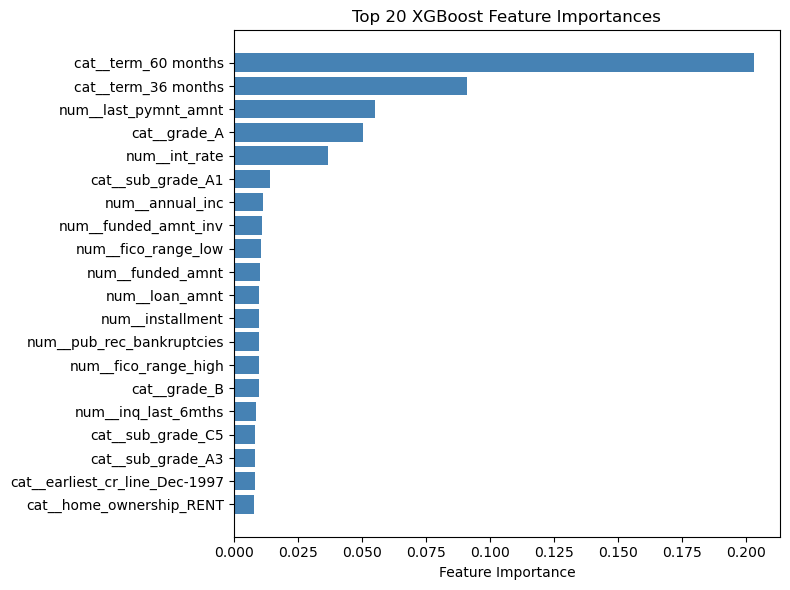

In [12]:
#GRID SEARCH

# -------------------
# 1. Target setup
# -------------------

df_tune = df.copy()

# -------------------
# 2. Drop leakage / ID / text columns
# -------------------
drop_cols = [
    "Unnamed: 0","id","emp_title","url","title","zip_code","addr_state",
    "issue_d","last_pymnt_d","next_pymnt_d","last_credit_pull_d",
    "out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
    "total_rec_prncp","total_rec_int","total_rec_late_fee",
    "recoveries","collection_recovery_fee",
    "last_fico_range_high","last_fico_range_low",
    "hardship_flag","hardship_type","hardship_reason","hardship_status",
    "deferral_term","hardship_amount","hardship_start_date","hardship_end_date",
    "payment_plan_start_date","hardship_length","hardship_dpd",
    "hardship_loan_status","orig_projected_additional_accrued_interest",
    "hardship_payoff_balance_amount","hardship_last_payment_amount",
    "debt_settlement_flag"
]
df_tune = df_tune.drop(columns=[c for c in drop_cols if c in df_tune.columns])

# -------------------
# 3. Clean percentages
# -------------------
percent_cols = ["int_rate", "revol_util", "sec_app_revol_util"]
for col in percent_cols:
    if col in df_tune.columns and df_tune[col].dtype == object:
        df_tune[col] = pd.to_numeric(
            df_tune[col].astype(str).str.strip().str.rstrip("%"),
            errors="coerce"
        )

# -------------------
# 4. Strip whitespace
# -------------------
for col in df_tune.select_dtypes(include="object").columns:
    df_tune[col] = df_tune[col].str.strip()

# -------------------
# 5. Split features
# -------------------
X = df_tune.drop(columns=["target"])
y = df_tune["target"]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# -------------------
# 6. Preprocessing
# -------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# -------------------
# 7. Pipeline with XGBClassifier
# -------------------
xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

# -------------------
# 8. Randomized Search
# -------------------
param_dist = {
    "classifier__n_estimators": [200, 300, 500, 800],
    "classifier__max_depth": [3, 5, 7, 9],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.6, 0.7, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.7, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring="roc_auc",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# -------------------
# 9. Train/test split
# -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

random_search.fit(X_train, y_train)

# -------------------
# 10. Results
# -------------------
print("Best Params:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

y_pred = random_search.predict(X_test)
y_proba = random_search.predict_proba(X_test)[:,1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# -------------------
# 11. Feature Importances
# -------------------
best_model = random_search.best_estimator_

# Recover feature names
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()
importances = best_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=True)

# Plot top 20
plt.figure(figsize=(8, 6))
top_df = importance_df.tail(20)
plt.barh(top_df["Feature"], top_df["Importance"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()


Numeric columns going into model: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recen

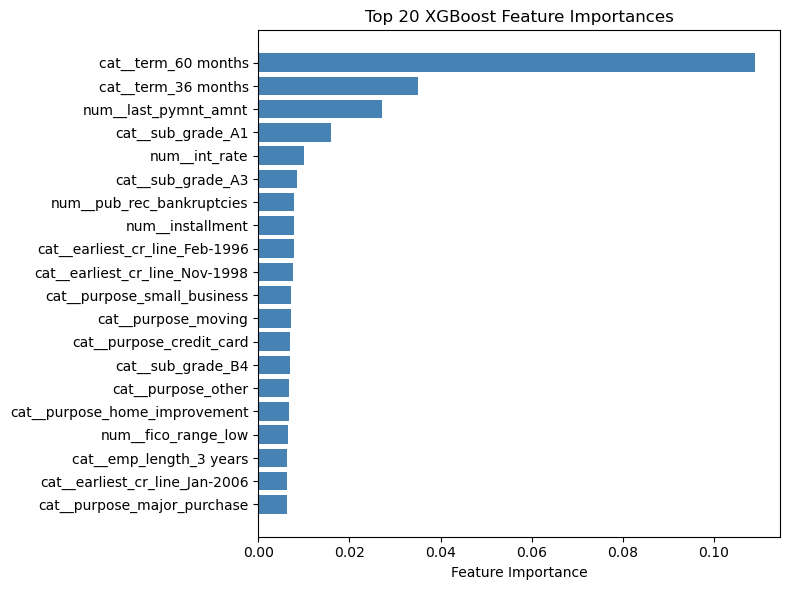

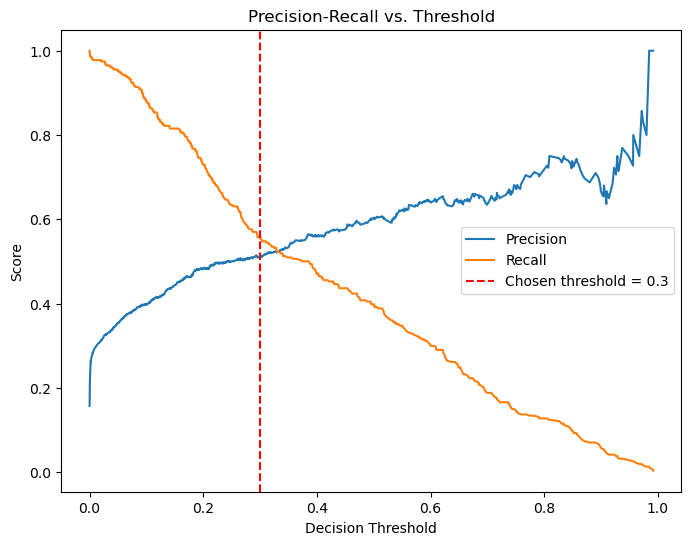

In [13]:
#Altering Threshold

# -------------------
# 2. Drop leakage / ID / text columns
# -------------------
drop_cols = [
    "Unnamed: 0","id","emp_title","url","title","zip_code","addr_state",
    "issue_d","last_pymnt_d","next_pymnt_d","last_credit_pull_d",
    "out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
    "total_rec_prncp","total_rec_int","total_rec_late_fee",
    "recoveries","collection_recovery_fee",
    "last_fico_range_high","last_fico_range_low",
    "hardship_flag","hardship_type","hardship_reason","hardship_status",
    "deferral_term","hardship_amount","hardship_start_date","hardship_end_date",
    "payment_plan_start_date","hardship_length","hardship_dpd",
    "hardship_loan_status","orig_projected_additional_accrued_interest",
    "hardship_payoff_balance_amount","hardship_last_payment_amount",
    "debt_settlement_flag"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# -------------------
# 3. Clean percentage strings
# -------------------
percent_cols = ["int_rate", "revol_util", "sec_app_revol_util"]
for col in percent_cols:
    if col in df.columns and df[col].dtype == object:
        df[col] = pd.to_numeric(
            df[col].astype(str).str.strip().str.rstrip("%"),
            errors="coerce"
        )

# -------------------
# 4. Strip whitespace in categorical variables
# -------------------
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()

# -------------------
# 5. Save a copy of cleaned dataframe (to see included cols)
# -------------------
df_cleaned = df.copy()
print("Numeric columns going into model:", df_cleaned.select_dtypes(include=[np.number]).drop(columns=["target"]).columns.tolist())
print("Categorical columns going into model:", df_cleaned.select_dtypes(include=["object"]).columns.tolist())

# -------------------
# 6. Split features into numeric vs categorical
# -------------------
numeric_features = df_cleaned.select_dtypes(include=[np.number]).drop(columns=["target"]).columns.tolist()
categorical_features = df_cleaned.select_dtypes(include=["object"]).columns.tolist()

# -------------------
# 7. Preprocessors
# -------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# -------------------
# 8. Full pipeline with XGBClassifier
# -------------------
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

# -------------------
# 9. Train/test split + train
# -------------------
X = df_cleaned.drop(columns=["target"])
y = df_cleaned["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

xgb_model.fit(X_train, y_train)

# -------------------
# 10. Evaluation with custom threshold
# -------------------
y_proba = xgb_model.predict_proba(X_test)[:,1]

# Choose a lower threshold (e.g., 0.3 instead of 0.5)
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(f"Classification Report (threshold={threshold}):")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# -------------------
# 11. Feature importances
# -------------------
feature_names = xgb_model.named_steps["preprocess"].get_feature_names_out()
importances = xgb_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(8, 6))
top_df = importance_df.tail(20)
plt.barh(top_df["Feature"], top_df["Importance"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# -------------------
# 12. (Optional) Precision-Recall Curve
# -------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(threshold, color="red", linestyle="--", label=f"Chosen threshold = {threshold}")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.show()
